# Welcome to the `PSPNet Starter` Workshop!
In this workshop, we'll build on the PSPNet_starter Notebook and build a full fledged PSPNet (Pyramid Scene Parsing Net), use it for Semantic Segmentation using Pytorch. We'll do the following tasks:

- **Dataset** : Download and use BDD100k dataset
- **Network** : Define PSPNet model using resnet50 backbone, Pyramid Pooling Module architecture and Auxilary loss
- **Training** : Train and validate model on the custom dataset
- **Evaluate** : Evaluate the model on Test Data and visualize results

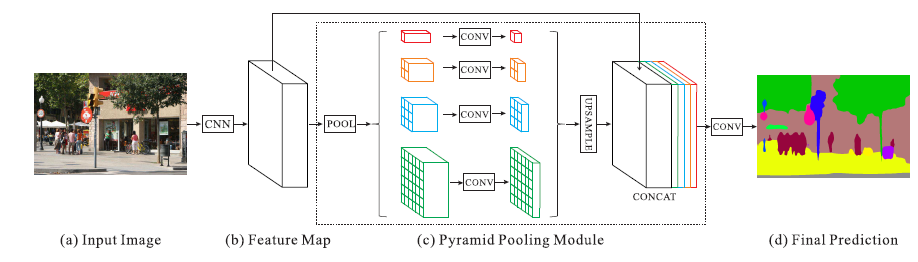

[Image reference](https://arxiv.org/abs/1612.01105)

## Imports

In [1]:
#Setup dataset
!python3 ../downloads/download_bdd.py

All files are present.
True


In [8]:
import sys
import os

# Add the path to the utils folder
sys.path.append(os.path.abspath('../utils'))

In [9]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

In [10]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

## 1. Dataset : Download and use BDD100k dataset

In [11]:
output_path = '../weights'

In [12]:
# load images and label data
images = np.load("./../dataset/bdd_image_180_320.npy")
labels = np.load("./../dataset/bdd_label_180_320.npy")

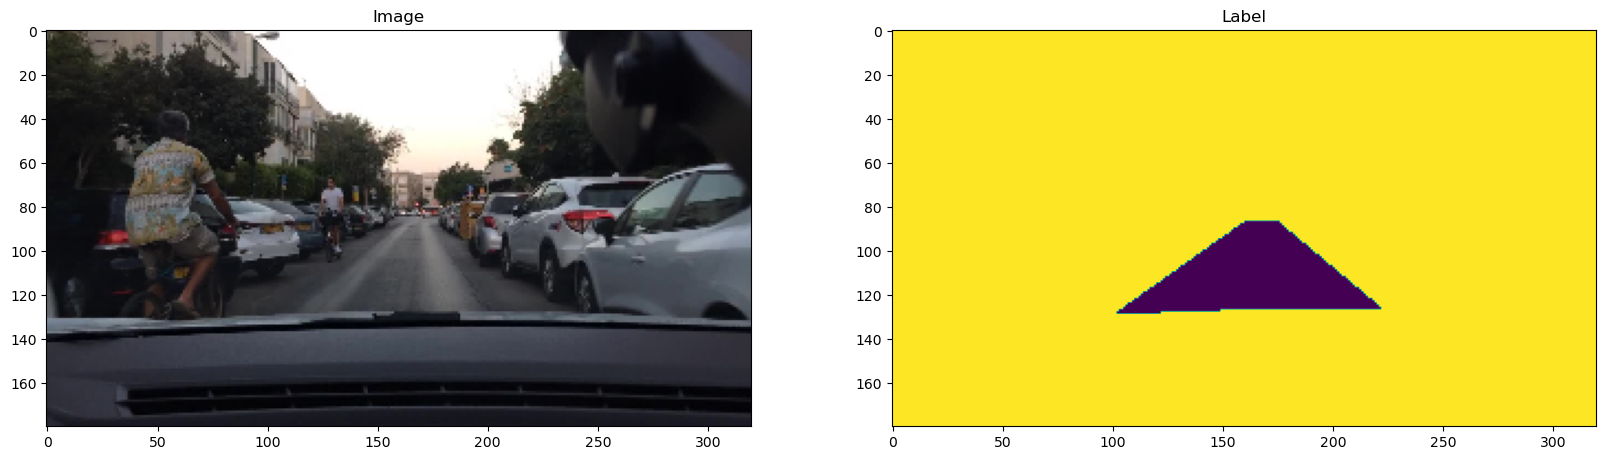

In [13]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=202
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model


In [14]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


### Show Sample images from dataset

In [15]:
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (206, 44, 40)),        # red
             Label("alternative", 1, (44, 108, 239)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


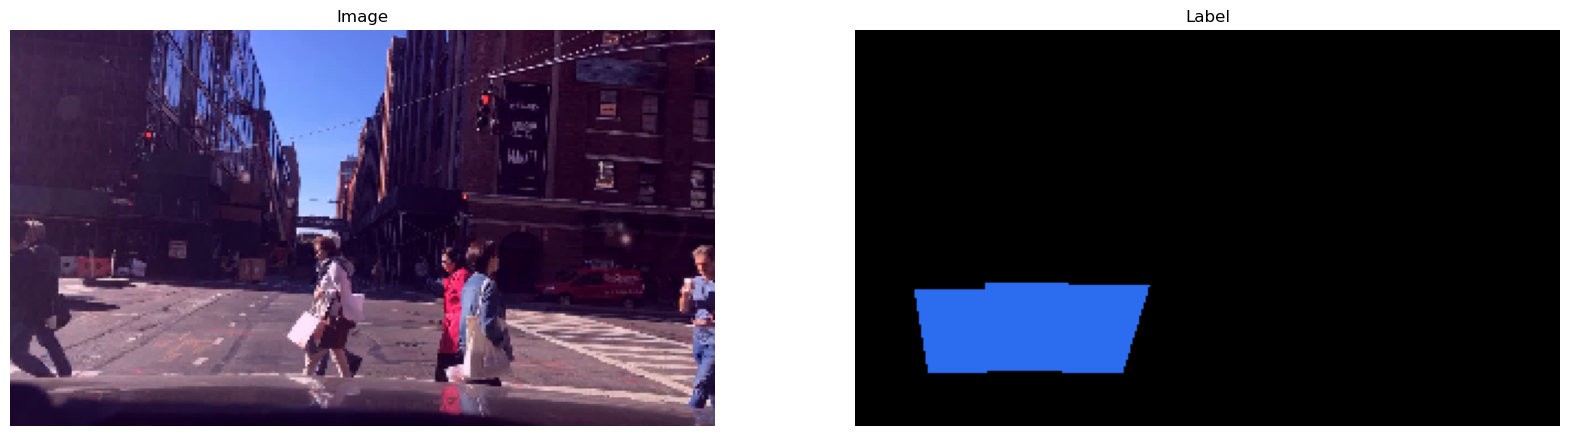

In [16]:
from utils import inverse_transform#, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network :
Define a PSPNet model using:
* A ResNet50 Backbone
* A Pyramid Pooling Module architecture
* And Auxilary branch
* A classifier head

All of the blocks are defined in the "PSPNet Blocks" workshop; so this is where you need to go first.

Once you have these blocks implemented, copy and paste them here.

### The Auxiliary Branch
For training, an auxiliary branch is used, it's doing exactly the same thing as the "main branch", but taking the output of Layer 3 as input (rather than the output of Layer 4)

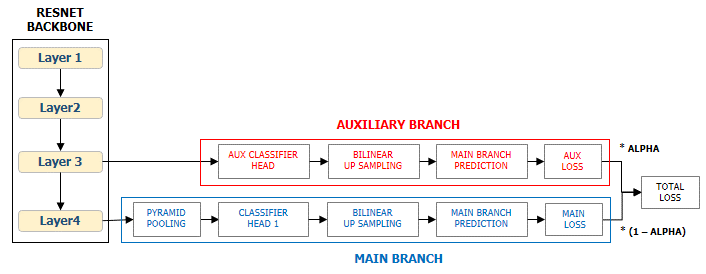

The authors proposed a separate auxiliary branch using `Layer3 output of Resnet backbones`.
- Auxiliary branch helps in setting initial values for the residual blocks.
- **Auxiliary branch is only used during training and not during inference**
- Auxiliary branch uses using similar classifier and loss function of the main branch.
- $Total Loss = \alpha * (auxloss) + (1 - \alpha) * (mainloss)$
**Alpha is a hyperparameter. Authors used `alpha - 0.4**

In [17]:
class auxiliary_branch(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(auxiliary_branch, self).__init__()
        self.aux = nn.Sequential(
                    nn.Conv2d(in_channels , 256, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(p=0.1),
                    nn.Conv2d(256, num_classes, kernel_size=1)
                )
    def forward(self, x, img_size):
        return F.interpolate(self.aux(x), img_size, mode='bilinear', align_corners=False)

### Pyramid Pooling Module

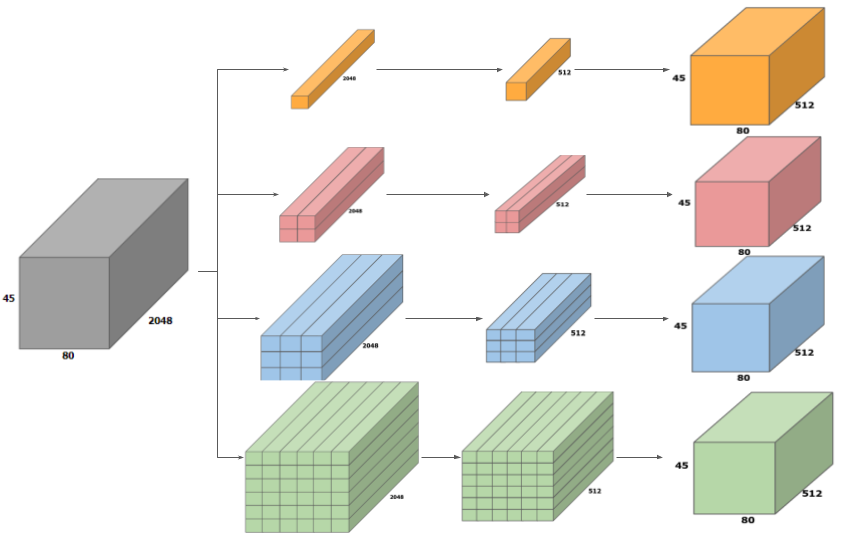

In [18]:
class pyramid_pooling_module(nn.Module):
    def __init__(self, in_channels, out_channels, bin_sizes):
        super(pyramid_pooling_module, self).__init__()

        # create pyramid pooling layers for each level
        self.pyramid_pool_layers = []
        for bin_sz in bin_sizes:
            self.pyramid_pool_layers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_sz),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        self.pyramid_pool_layers = nn.ModuleList(self.pyramid_pool_layers)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for layer in self.pyramid_pool_layers:
            out.append(F.interpolate(layer(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

### PSPNet Model definition

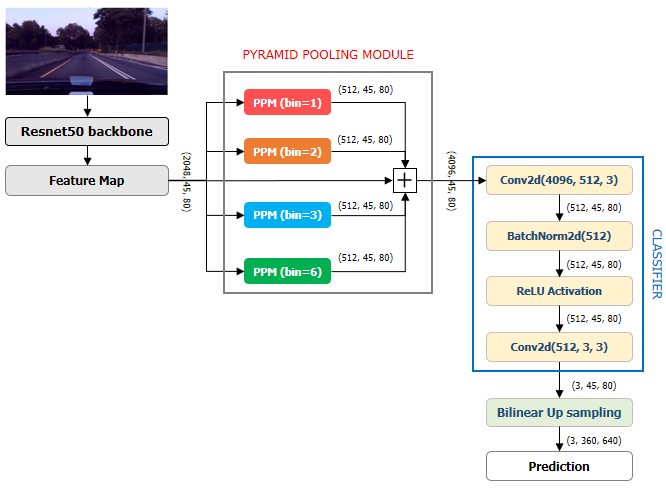

In [19]:
from torchvision.models import resnet50

class PSPNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_aux=False):
        super(PSPNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.out_channels=512
        # backbone layers
        backbone = resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        # Pyramid pooling module components
        ppm_in_channels = int(backbone.fc.in_features)
        self.ppm =pyramid_pooling_module(in_channels=ppm_in_channels, out_channels=self.out_channels, bin_sizes=[1,2,3,6])

        # classifier head
        self.cls = nn.Sequential(
                    nn.Conv2d(ppm_in_channels*2,self.out_channels, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(self.out_channels),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(p=0.1),
                    nn.Conv2d(self.out_channels, num_classes, kernel_size=1))

        # main branch is composed of PPM + Classifier
        self.main_branch = nn.Sequential(self.ppm,self.cls)

        # Define Auxilary branch if specified
        self.use_aux = use_aux
        if(self.training and use_aux):
            self.use_aux = True
            self.aux_branch =  nn.Sequential(
                    nn.Conv2d(int(ppm_in_channels/2) , 256, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(p=0.1),
                    nn.Conv2d(256, num_classes, kernel_size=1)
                )
            #TODO: Call the Auxiliary Branch


    def forward(self, x):
        input_size = x.shape[-2:]

        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_aux = self.layer3(x)
        x = self.layer4(x_aux)

        # Get Main branch output
        main_output = self.main_branch(x)
        main_output = F.interpolate(main_output, size=input_size, mode='bilinear')

        # If needed, get auxiliary branch output
        if(self.training and self.use_aux):
            aux_output = F.interpolate(self.aux_branch(x_aux), size=input_size, mode='bilinear')
            output = {}
            output['aux'] = aux_output
            output['main'] = main_output
            return output

        return main_output

## 3. Training
Like for the UNet project, we'll now train the model, and then evaluate it.

In [20]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function
from utils import pspnet_loss

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 5
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'PSPNet_resnet50_aux'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = pspnet_loss(num_classes = NUM_CLASSES, aux_weight=0.4)

# create model, optimizer, lr_scheduler and pass to training function
model = PSPNet(in_channels=3, num_classes=NUM_CLASSES, use_aux=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

## Run Train/Evaluate Function
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

/home/avsingh/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avsingh/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting 1 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.19it/s]

Epoch: 1, trainLoss:0.59180, validationLoss:0.46793, meanIoU: 0.62


RuntimeError: Parent directory weights does not exist.

## 4. Evaluate

In [22]:
MODEL_EPOCH = 40
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}_{MODEL_EPOCH}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

/tmp/ipykernel_3215068/204309118.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}_{MODEL_EPOCH}.pt', map_loc


Model has 0.7834726280946859 mean IoU in test set


In [23]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


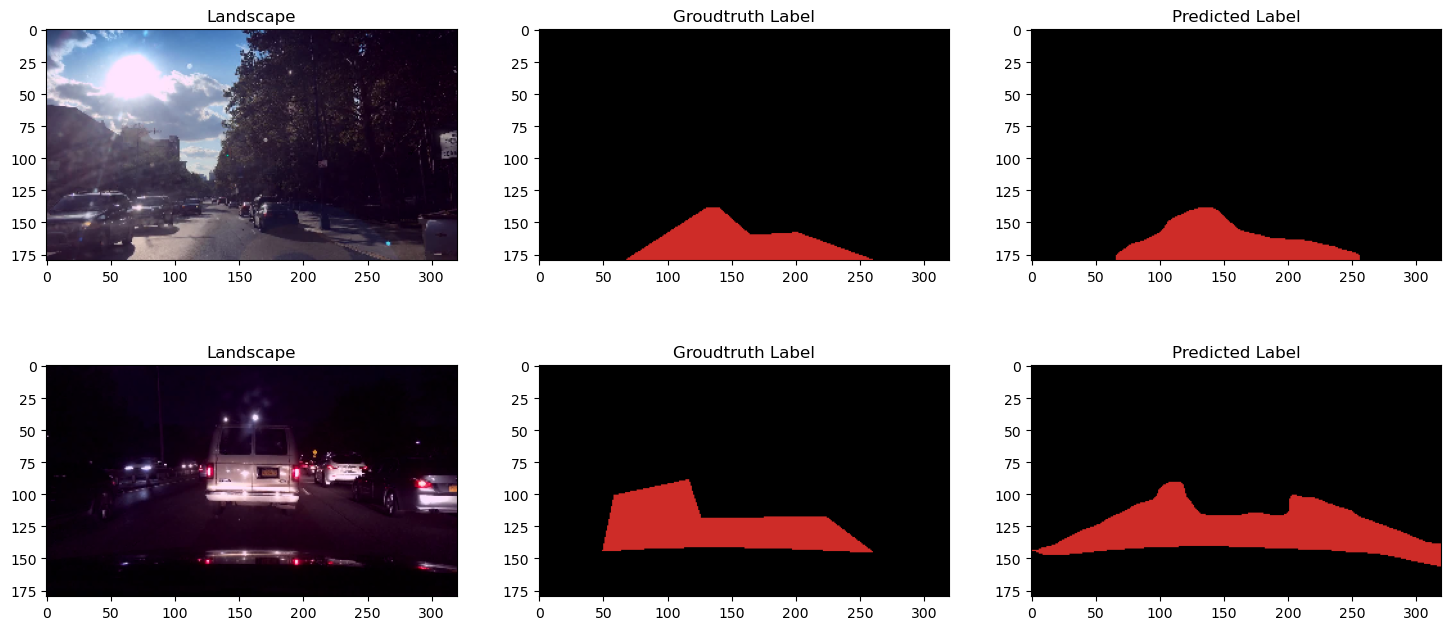

In [24]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)


## Test on sample video
If you want to test it on a real video, you can try:

```python
from utils import predict_video
predict_video(model, model_name, input_video_path, output_dir,
            target_width, target_height, device)
```

In out case, we'll have several videos we can try our model on:
* Highway (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi`
* Residential (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi`
* Campus (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi`
* Stuttgart (Cityscapes)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi`


In [26]:
from utils import predict_video
predict_video(model, "PSPNet5epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cuda", train_id_to_color)

100%|██████████| 1170/1170 [01:08<00:00, 17.20it/s]
